<a href="https://colab.research.google.com/github/aasem/fyp-changedetection/blob/main/road_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Extraction from Satellite Imagery

## Preliminaries

In [ ]:
!pip install kaggle

In [ ]:
!pwd

/content


In [ ]:
!mkdir kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"
!chmod 600 /content/kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

100% 3.79G/3.79G [01:32<00:00, 69.4MB/s]
100% 3.79G/3.79G [01:32<00:00, 44.3MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip 

Streaming output truncated to the last 5000 lines.
  inflating: train/723199_sat.jpg    
  inflating: train/723226_mask.png   
  inflating: train/723226_sat.jpg    
  inflating: train/723436_mask.png   
  inflating: train/723436_sat.jpg    
  inflating: train/723483_mask.png   
  inflating: train/723483_sat.jpg    
  inflating: train/723622_mask.png   
  inflating: train/723622_sat.jpg    
  inflating: train/723722_mask.png   
  inflating: train/723722_sat.jpg    
  inflating: train/723970_mask.png   
  inflating: train/723970_sat.jpg    
  inflating: train/723990_mask.png   
  inflating: train/723990_sat.jpg    
  inflating: train/724095_mask.png   
  inflating: train/724095_sat.jpg    
  inflating: train/724431_mask.png   
  inflating: train/724431_sat.jpg    
  inflating: train/724485_mask.png   
  inflating: train/724485_sat.jpg    
  inflating: train/724705_mask.png   
  inflating: train/724705_sat.jpg    
  inflating: train/724870_mask.png   
  inflating: train/724870_sat.jpg    

In [ ]:
# Definitions
import os, random, tqdm, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
import albumentations as album

!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

import warnings
warnings.filterwarnings("ignore")


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-5aoz37va
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-5aoz37va
     |████████████████████████████████| 47.7 MB 1.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112538 sha256=44e27558cc2c21844019929436b14814f99af8a52351cd5769a1b645830d7e1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xj1k2gvg/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


     |████████████████████████████████| 88 kB 5.5 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 376 kB 48.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=313ee3af36852bdb3c2e5e528de90d55a5c021264caff76c4c06dfaf30880050
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=08938aab04e6ba552f839b80b47f0374118a29e9bf674818335530f1925eaf0e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


## Data Reading and Setup

In [ ]:
class_dictionary = pd.read_csv('/content/class_dict.csv')
metadata = pd.read_csv('/content/metadata.csv')

meta_train = metadata[metadata["split"] == "train"]
meta_test = metadata[metadata["split"] == "test"]
meta_valid = metadata[metadata["split"] == "valid"]

meta_train.drop('split', inplace=True, axis=1)
meta_test.drop(['split', 'mask_path'], inplace=True, axis=1)
meta_valid.drop(['split', 'mask_path'], inplace=True,axis=1)

meta_train["sat_image_path"] = meta_train["sat_image_path"].apply(lambda sat_path:os.path.join('/content', sat_path))
meta_train["mask_path"] = meta_train["mask_path"].apply(lambda mask_path:os.path.join('/content', mask_path))
meta_test["sat_image_path"] = meta_test["sat_image_path"].apply(lambda sat_path:os.path.join('/content', sat_path))

# Shuffle the training data
meta_train = meta_train.sample(frac=1).reset_index(drop=True)

# Train/ Validate Split
validate = meta_train.sample(frac=0.1,random_state=100)
train = meta_train.drop(validate.index)

train.reset_index(drop=True, inplace=True)
validate.reset_index(drop=True, inplace=True)

In [ ]:
len(train), len(validate)

(5603, 623)

In [ ]:
train.head(-1)

,image_id,sat_image_path,mask_path
0,688218,/content/train/688218_sat.jpg,/content/train/688218_mask.png
1,393590,/content/train/393590_sat.jpg,/content/train/393590_mask.png
2,292384,/content/train/292384_sat.jpg,/content/train/292384_mask.png
3,412908,/content/train/412908_sat.jpg,/content/train/412908_mask.png
4,296759,/content/train/296759_sat.jpg,/content/train/296759_mask.png
...,...,...,...
5597,833625,/content/train/833625_sat.jpg,/content/train/833625_mask.png
5598,629683,/content/train/629683_sat.jpg,/content/train/629683_mask.png
5599,386600,/content/train/386600_sat.jpg,/content/train/386600_mask.png
5600,406774,/content/train/406774_sat.jpg,/content/train/406774_mask.png


In [ ]:
validate.head(-1)

,image_id,sat_image_path,mask_path
0,442085,/content/train/442085_sat.jpg,/content/train/442085_mask.png
1,331632,/content/train/331632_sat.jpg,/content/train/331632_mask.png
2,165784,/content/train/165784_sat.jpg,/content/train/165784_mask.png
3,893704,/content/train/893704_sat.jpg,/content/train/893704_mask.png
4,800005,/content/train/800005_sat.jpg,/content/train/800005_mask.png
...,...,...,...
617,185247,/content/train/185247_sat.jpg,/content/train/185247_mask.png
618,562586,/content/train/562586_sat.jpg,/content/train/562586_mask.png
619,361334,/content/train/361334_sat.jpg,/content/train/361334_mask.png
620,896391,/content/train/896391_sat.jpg,/content/train/896391_mask.png


## Inspecting Class Names and Shortlisting Classes
It is sometimes useful to shortlist classes which we want to segment in case of large datasets with many classes.

In [ ]:
# Get class names and RGB values
classnames = class_dictionary["name"].tolist()
rgb_values = class_dictionary[["r","g","b"]].values.tolist()
print('All the Classes in the Dataset')
print('Class Names: ', classnames)
print('Class RGB values: ', rgb_values)

All the Classes in the Dataset
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [ ]:
select_classes = ['road','background']

# Get RGB values of required classes
select_class_indices = [classnames.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(rgb_values)[select_class_indices]
print('Class Names: ', select_class_indices)
print('Class RGB values: ', select_class_rgb_values)

Class Names:  [0, 1]
Class RGB values:  [[255 255 255]
 [  0   0   0]]


## Helper Functions (Visualization and One Hot Encoding)

In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
        
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class RoadsDataset(torch.utils.data.Dataset):

    """DeepGlobe Road Extraction Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

## Visualizing Sample Image and Corresponding Mask

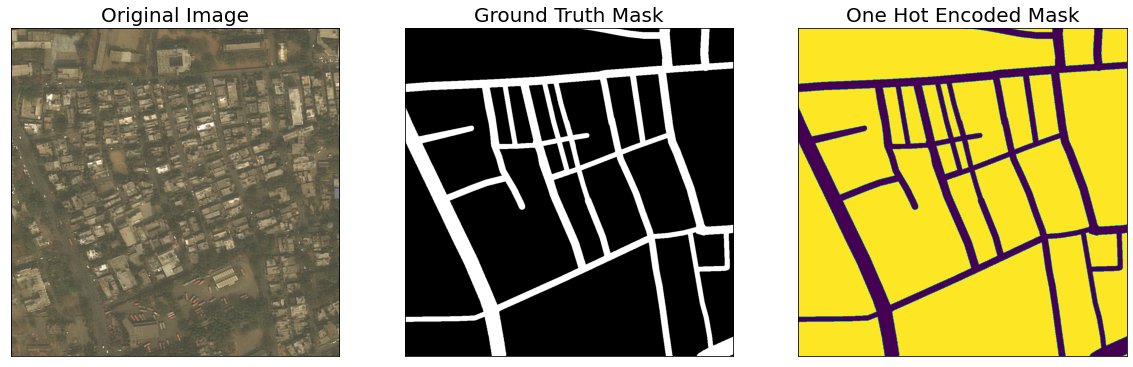

In [ ]:
dataset = RoadsDataset(train, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

## Augmenting the Dataset

In [ ]:
def get_training_augmentation():
    train_transform = [album.HorizontalFlip(p=0.5), album.VerticalFlip(p=0.5)]
    return album.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

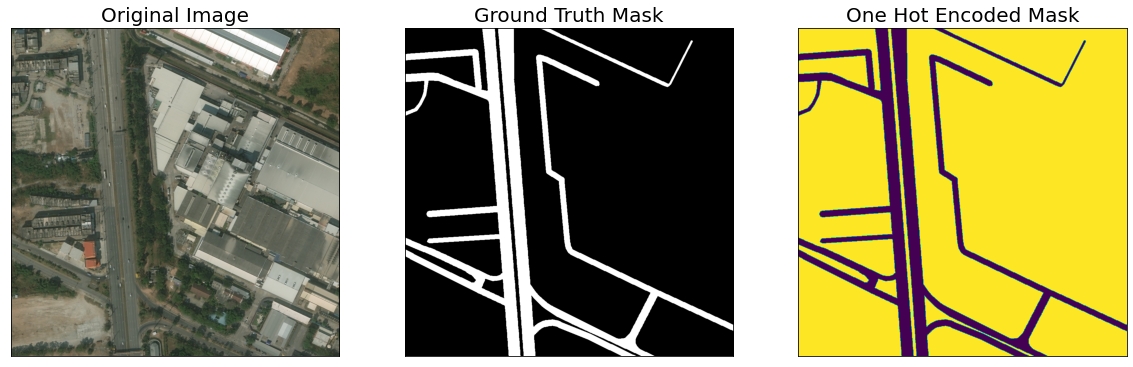

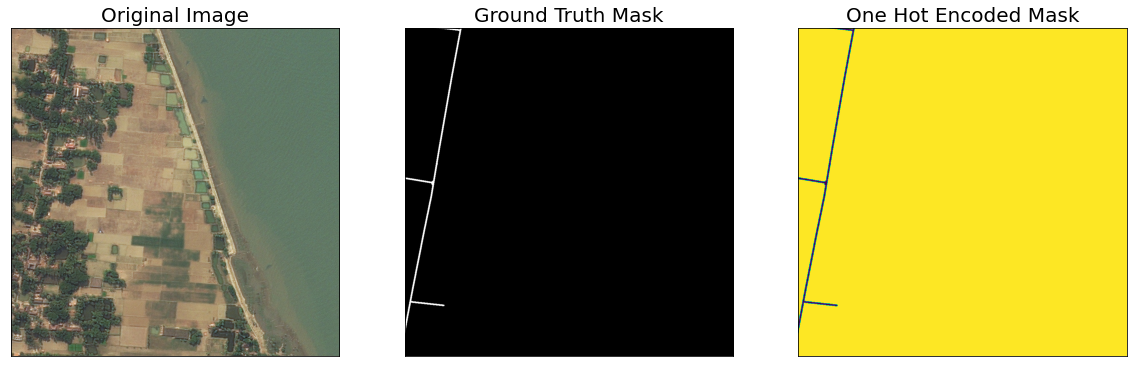

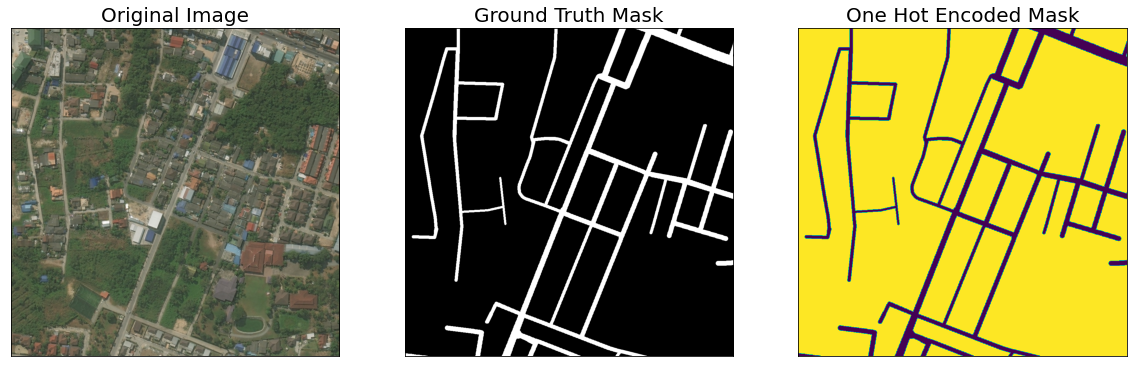

In [ ]:
augmented_dataset = RoadsDataset(
    train, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Model Definition (DeepLapV3+)

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Get Training/ Validation Data Loaders

In [ ]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    train, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    validate, 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

## Set Hyperparameters

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 1

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_avail
                      able() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/road-extraction-from-satellite-images-deeplabv3/best_model.pth'):
    model = torch.load('/content/road-extraction-from-satellite-images-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

SyntaxError: ignored

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Training the Model

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
train:   0%|          | 1/1401 [00:07<3:06:16,  7.98s/it, dice_loss - 0.565, iou_score - 0.09157]


RuntimeError: ignored

## Prediction on Test Dataset

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth'):
    best_model = torch.load('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

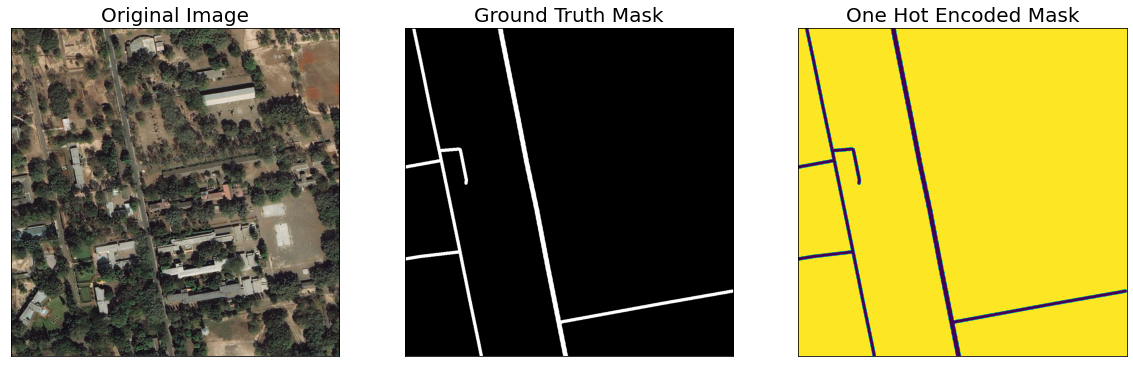

In [ ]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    validate, 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = RoadsDataset(
    validate,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_road_heatmap = pred_road_heatmap
    )

NameError: ignored

## Model Evaluation (Test Dataset)

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid:   0%|          | 0/623 [00:00<?, ?it/s]


RuntimeError: ignored

## Plot Metrics

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

""


In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

AttributeError: ignored

<Figure size 1440x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()